In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from pylab import rcParams

In [2]:
dataset_1 = pd.read_csv('data_1.csv', 
                            parse_dates={'time' : ['Date time']}, 
                            infer_datetime_format=True, 
                            index_col='time')

dataset_2 = pd.read_csv('data_2.csv', 
                            parse_dates={'time' : ['Date time']}, 
                            infer_datetime_format=True, 
                            index_col='time')

cols = list(dataset_1)[0:5]

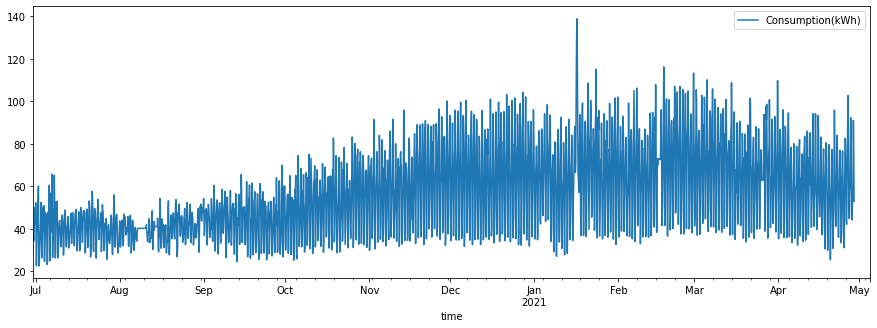

<Figure size 1080x360 with 0 Axes>

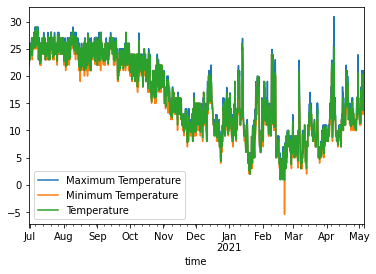

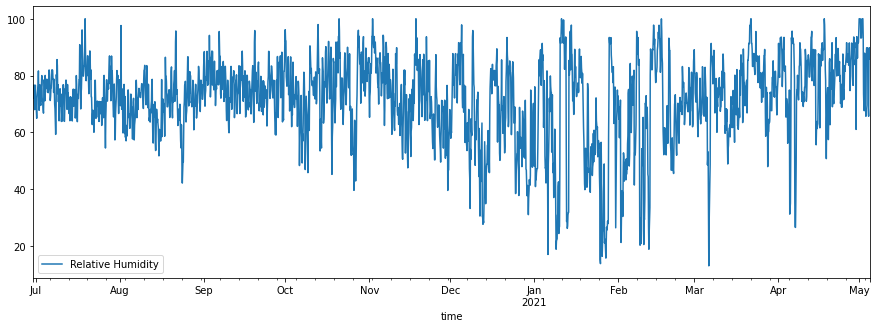

In [3]:
plt.figure(figsize=(15,5))
dataset_1.iloc[:,0].plot(legend=True)
plt.show()
plt.figure(figsize=(15,5))
dataset_1.iloc[:,1:4].plot(legend=True)
plt.show()
plt.figure(figsize=(15,5))
dataset_1.iloc[:,4].plot(legend=True)
plt.show()

In [4]:
dataset_1 = dataset_1[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_1)):
        dataset_1[i][j] = dataset_1[i][j].replace(',', '')

dataset_1 = dataset_1.astype(float)
dataset1_training = dataset_1.to_numpy()

In [5]:
std_scaler = StandardScaler()
dataset1_scaled = std_scaler.fit_transform(dataset1_training)

std_scaler_predict = StandardScaler()
std_scaler_predict.fit_transform(dataset1_training[:, 0:1])

array([[-0.98662329],
       [-1.12655958],
       [-0.99038442],
       ...,
       [        nan],
       [        nan],
       [        nan]])

In [6]:
X_train = []
Y_train = []

future_step = 48   
past_step = 72     

for i in range(past_step, len(dataset1_scaled) - future_step +1):
    X_train.append(dataset1_scaled[i - past_step:i, 0:dataset_1.shape[1] - 1])
    Y_train.append(dataset1_scaled[i + future_step - 1:i + future_step, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [7]:
model = Sequential()

model.add(LSTM(units=112, 
               return_sequences=True, 
               input_shape=(past_step, dataset_1.shape[1]-1)))

model.add(LSTM(units=8, 
               return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(units=1, 
                activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.01), 
              loss='mean_squared_error', 
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train, 
                    Y_train, 
                    shuffle=True, 
                    epochs=50, 
                    validation_split=0.2, 
                    verbose=1, 
                    batch_size=256)

Epoch 1/50
8/8 [==============================] - 47s 897ms/step - loss: 0.9262 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/50
8/8 [==============================] - 4s 553ms/step - loss: 0.6690 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/50
8/8 [==============================] - 5s 576ms/step - loss: 0.4071 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/50
8/8 [==============================] - 4s 548ms/step - loss: 0.2736 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/50
8/8 [==============================] - 5s 575ms/step - loss: 0.2409 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/50
8/8 [==============================] - 5s 598ms/step - loss: 0.2015 - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/50
8/8 [==============================] - 5s 583ms/step - loss: 0.1739 - accuracy: 0.0000e+00 - val_loss: nan - val_accur

In [9]:
future_step_values_scaled = model.predict(X_train[-future_step:])
train_step_values_scaled = model.predict(X_train[past_step:])

In [10]:
future_timestamp = pd.date_range(dataset_1.index[-future_step], periods=future_step, freq='3h').tolist()

future_timestamp_ = []

for timestamp_current in future_timestamp:
    future_timestamp_.append(timestamp_current.date())

In [11]:
future_step_values_unscaled = std_scaler_predict.inverse_transform(future_step_values_scaled)
train_step_values_unscaled = std_scaler_predict.inverse_transform(train_step_values_scaled)

TRUE_VALUES= pd.DataFrame(dataset1_training[:, 0:5],
                              columns=['Consumption(kWh)',
                                       'Maximum Temperature', 
                                       'Minimum Temperature', 
                                       'Temperature', 
                                       'Relative Humidity']).set_index(
                                            pd.Series(dataset_1.index))
TRAIN_VALUES = pd.DataFrame(train_step_values_unscaled, 
                                columns=['Consumption(kWh)']).set_index(
                                            pd.Series(dataset_1.index[2*past_step+future_step-1:]))
FUTURE_VALUES = pd.DataFrame(future_step_values_unscaled, 
                                  columns=['Consumption(kWh)']).set_index(
                                            pd.Series(future_timestamp))
dataset2_training = dataset_2.to_numpy()

FUTURE_TRUE_VALUES=pd.DataFrame(dataset2_training[:, 0:1],
                              columns=['Consumption(kWh)']).set_index(
                                            pd.Series(dataset_2.index))

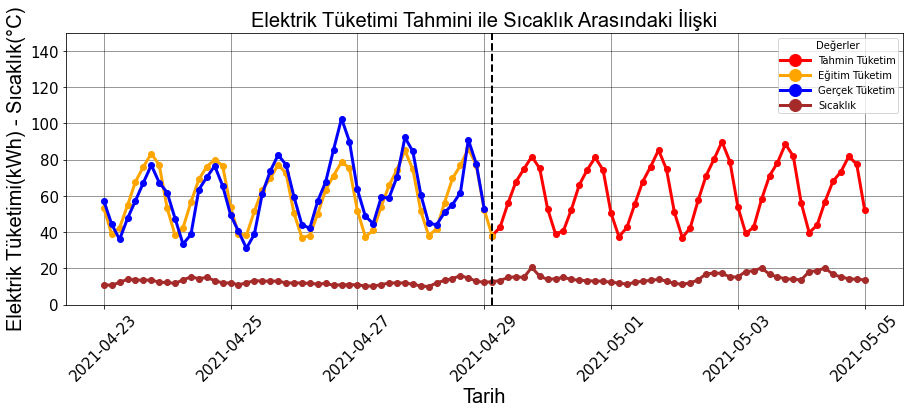

In [12]:
rcParams['figure.figsize'] =15, 5
plt.rcParams.update({'font.size': 10})
START_DATE = pd.to_datetime('2021-04-23')
FINISH_DATE = dataset_1.index[-future_step]
plt.plot(FUTURE_VALUES.index, 
         FUTURE_VALUES['Consumption(kWh)'],
         'go-', color='red', label='Tahmin Tüketim', linewidth=3)
plt.plot(TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE].index,
         TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE]['Consumption(kWh)'],
         'go-', color='orange', label='Eğitim Tüketim', linewidth=3)
plt.plot(TRUE_VALUES.loc[START_DATE:].index,
         TRUE_VALUES.loc[START_DATE:]['Consumption(kWh)'],
         'go-', color='blue', label='Gerçek Tüketim', linewidth=3)
plt.plot(TRUE_VALUES.loc[START_DATE:].index,
         TRUE_VALUES.loc[START_DATE:]['Temperature'],
         'go-', color='brown', label='Sıcaklık', linewidth=3)
plt.axvline(x = FINISH_DATE,color='black',linewidth=2,linestyle='--')
plt.grid(which='major',color='#000000',alpha=0.50)
plt.ylim(ymin=0,ymax=150)
plt.legend(loc=0,fontsize="medium",markerscale=2,title="Değerler",
           title_fontsize=10,
           borderpad=0.2,
           handlelength=3)
plt.title('Elektrik Tüketimi Tahmini ile Sıcaklık Arasındaki İlişki',family='Arial',fontsize=20)
plt.xlabel('Tarih',family='Arial',fontsize=20)
plt.ylabel('Elektrik Tüketimi(kWh) - Sıcaklık(°C)',family='Arial',fontsize=20)
plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('LSTM-Sıcaklık Arasındaki İlişki.jpeg',bbox_inches='tight')
plt.show()


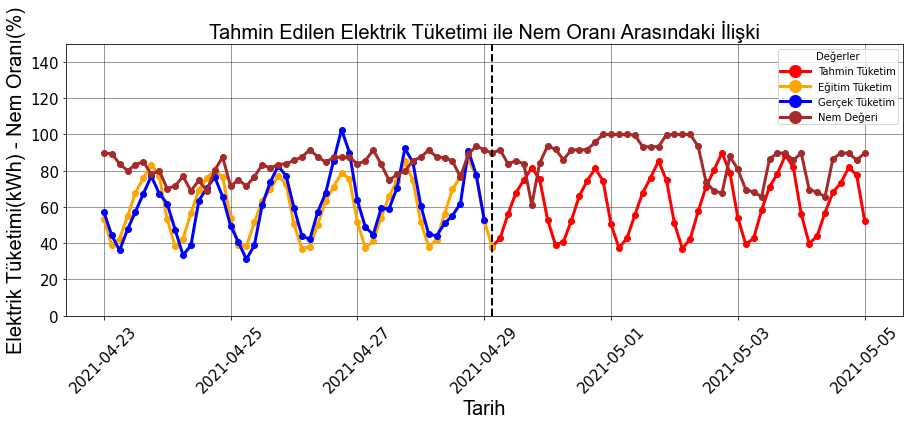

In [13]:
rcParams['figure.figsize'] =15, 5
plt.rcParams.update({'font.size': 10})
START_DATE = pd.to_datetime('2021-04-23')
FINISH_DATE = dataset_1.index[-future_step]
plt.plot(FUTURE_VALUES.index, 
         FUTURE_VALUES['Consumption(kWh)'],
         'go-', color='red', label='Tahmin Tüketim', linewidth=3)

plt.plot(TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE].index, 
         TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE]['Consumption(kWh)'],
         'go-', color='orange', label='Eğitim Tüketim', linewidth=3)
plt.plot(TRUE_VALUES.loc[START_DATE:].index, 
         TRUE_VALUES.loc[START_DATE:]['Consumption(kWh)'],
         'go-', color='blue', label='Gerçek Tüketim', linewidth=3)

plt.plot(TRUE_VALUES.loc[START_DATE:].index,
         TRUE_VALUES.loc[START_DATE:]['Relative Humidity'],
         'go-', color='brown', label='Nem Değeri', linewidth=3)

plt.axvline(x = FINISH_DATE, color='black', linewidth=2, linestyle='--')
plt.grid(which='major', color='#000000', alpha=0.50)
plt.ylim(ymin=0,ymax=150)
plt.legend(loc=0,
           fontsize="medium",
           markerscale=2,
           title="Değerler",
           title_fontsize=10,
           borderpad=0.2,
           handlelength=3)
plt.title('Tahmin Edilen Elektrik Tüketimi ile Nem Oranı Arasındaki İlişki', family='Arial', fontsize=20)
plt.xlabel('Tarih', family='Arial', fontsize=20)
plt.ylabel('Elektrik Tüketimi(kWh) - Nem Oranı(%)', family='Arial', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('LSTM-Nem Oranı Arasındaki İlişki.jpeg', bbox_inches='tight')
plt.show()


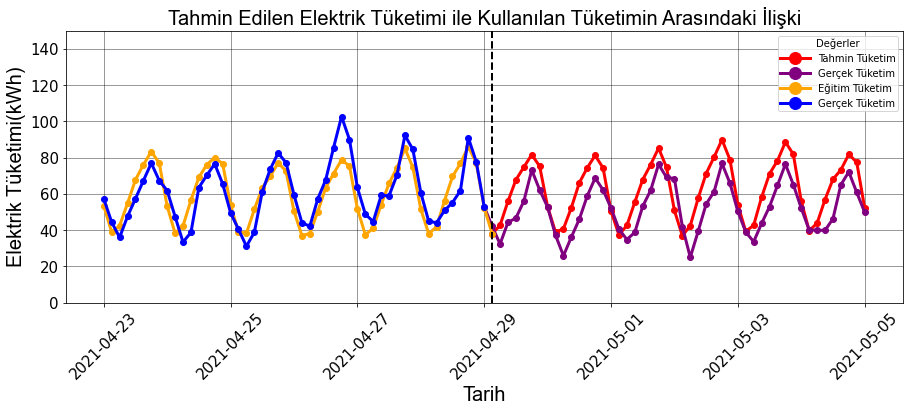

In [16]:
rcParams['figure.figsize'] =15, 5
plt.rcParams.update({'font.size': 10})
START_DATE = pd.to_datetime('2021-04-23')
FINISH_DATE = dataset_1.index[-future_step]
plt.plot(FUTURE_VALUES.index, 
         FUTURE_VALUES['Consumption(kWh)'],
         'go-', color='red', label='Tahmin Tüketim', linewidth=3)
plt.plot(FUTURE_TRUE_VALUES.index, 
         FUTURE_TRUE_VALUES['Consumption(kWh)'],
         'go-', color='purple', label='Gerçek Tüketim', linewidth=3)


plt.plot(TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE].index, 
         TRAIN_VALUES.loc[START_DATE:
                              FINISH_DATE]['Consumption(kWh)'],
         'go-', color='orange', label='Eğitim Tüketim', linewidth=3)
plt.plot(TRUE_VALUES.loc[START_DATE:].index, 
         TRUE_VALUES.loc[START_DATE:]['Consumption(kWh)'],
         'go-', color='blue', label='Gerçek Tüketim', linewidth=3)

plt.axvline(x = FINISH_DATE, color='black', linewidth=2, linestyle='--')
plt.grid(which='major', color='#000000', alpha=0.50)
plt.ylim(ymin=0,ymax=150)
plt.legend(loc=0,
           fontsize="medium",
           markerscale=2,
           title="Değerler",
           title_fontsize=10,
           borderpad=0.2,
           handlelength=3)
plt.title('Tahmin Edilen Elektrik Tüketimi ile Kullanılan Tüketimin Arasındaki İlişki', family='Arial', fontsize=20)
plt.xlabel('Tarih', family='Arial', fontsize=20)
plt.ylabel('Elektrik Tüketimi(kWh)', family='Arial', fontsize=20)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('LSTM-Tahmin Edilen Elektrik Tüketimi ile Kullanılan Tüketimin Arasındaki İlişki.jpeg', bbox_inches='tight')
plt.show()
